<style>
  .intro-box {
    border: 2px solid #4CAF50;
    border-radius: 10px;
    padding: 20px;
    background-color: #f0fff4;
    font-family: Arial, sans-serif;
    color: #333;
  }
  .intro-box h2 {
    color: #2e7d32;
    margin-top: 0;
  }
  .intro-box ul {
    padding-left: 20px;
  }
  .intro-box li {
    margin-bottom: 8px;
  }
  .intro-box code {
    background-color: #e8f5e9;
    padding: 2px 5px;
    border-radius: 5px;
    font-family: monospace;
  }
</style>

<div class="intro-box">
  <h2>🦷 Teeth Disease Classification Using Deep Learning</h2>

  <p>
    This notebook demonstrates a full deep learning pipeline for classifying various teeth diseases from images. It uses a dataset organized into three main folders:
    <strong>Training</strong>, <strong>Validation</strong>, and <strong>Testing</strong>, each containing subfolders for disease categories like 
    <code>OC</code>, <code>CaS</code>, <code>OT</code>, <code>CoS</code>, <code>Gum</code>, <code>MC</code>, and <code>OLP</code>.
  </p>

  <h3>📌 Objectives:</h3>
  <ul>
    <li>Load and Explore the data by showing images for each class</li>
    <li>Apply data augmentation to enhance generalization.</li>
    <li>train CNN model to process the  data</li>
    <li>evaluate the model using various metrics like accuarcy classification report .</li>
    <li>Deploy the trained model for inference on unseen data.</li>
  </ul>

  <h3>🧠 Dataset Overview:</h3>
  <p>
    The dataset contains labeled intraoral images across 7 disease categories. Proper preprocessing and augmentation are applied to improve robustness.
  </p>
</div>


In [2]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import random
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-07-02 00:01:05.901465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751414466.112901      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751414466.174527      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## content of data folder 

In [3]:
base_path = '/kaggle/input/teeth-dataset'

print("Inside:", base_path)
first_level = os.listdir(base_path)
print(first_level)

# Go deeper into each folder under 'Teeth_Dataset'
for folder in first_level:
    full_path = os.path.join(base_path, folder)
    print(f"\nInside: {full_path}")
    second_level = os.listdir(full_path)
    print(second_level)
    print()

    # Now list each class folder and count files
    for subfolder in second_level:
        sub_path = os.path.join(full_path, subfolder)
        files = os.listdir(sub_path)
        print(f"  → {subfolder} contains {files} ")

Inside: /kaggle/input/teeth-dataset
['Teeth_Dataset']

Inside: /kaggle/input/teeth-dataset/Teeth_Dataset
['Validation', 'Training', 'Testing']

  → Validation contains ['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP'] 
  → Training contains ['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP'] 
  → Testing contains ['OC', 'outputs', 'output', 'CaS', 'out', 'OT', 'CoS', 'output_image.jpg', 'Gum', 'MC', 'OLP'] 


## Loading the data 

In [4]:
base_path = "/kaggle/input/teeth-dataset/Teeth_Dataset"

train_data = tf.keras.utils.image_dataset_from_directory(
    base_path + "/Training",
    image_size=(224, 224),
    batch_size=32
)

val_data = tf.keras.utils.image_dataset_from_directory(
    base_path + "/Validation",
    image_size=(224, 224),
    batch_size=32
)

test_data = tf.keras.utils.image_dataset_from_directory(
    base_path + "/Testing",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 3087 files belonging to 7 classes.


I0000 00:00:1751414498.674202      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1028 files belonging to 7 classes.
Found 1508 files belonging to 10 classes.


## show the distribution of the classes 

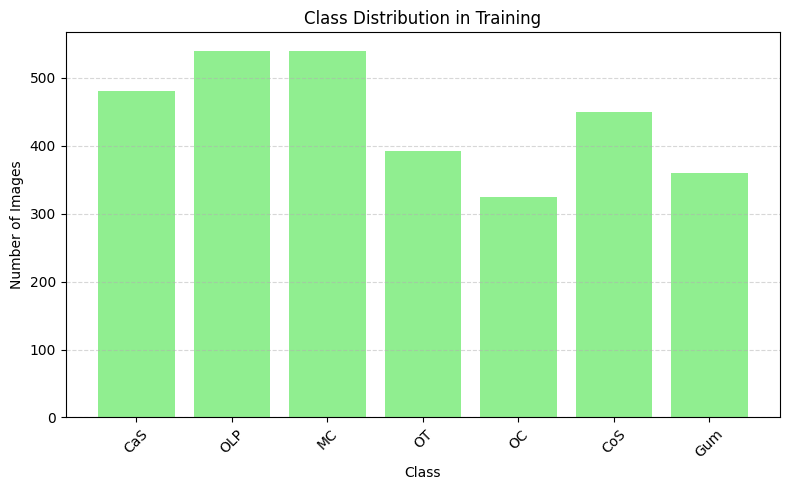

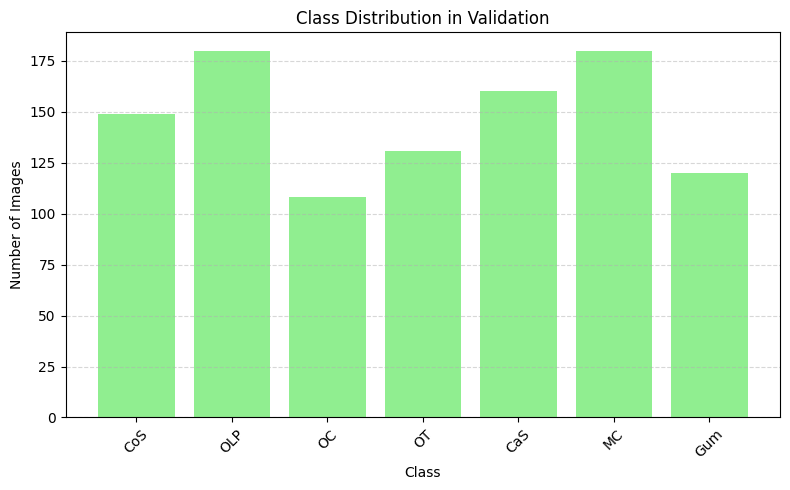

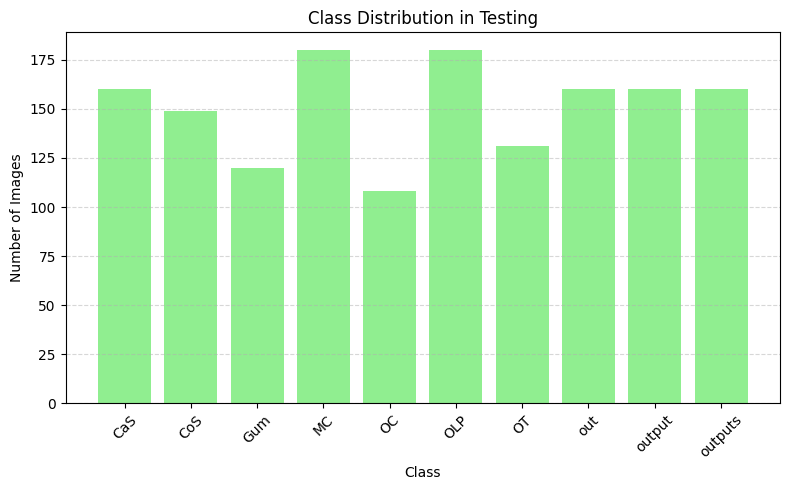

In [5]:
from collections import Counter

def plot_class_distribution(dataset, dataset_name):
    
    class_names = dataset.class_names

    
    class_counts = Counter()
    for images, labels in dataset:
        label_vals = labels.numpy()
        for label in label_vals:
            class_counts[class_names[label]] += 1


    labels = list(class_counts.keys())
    counts = list(class_counts.values())

   
    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts, color='lightgreen')
    plt.title(f'Class Distribution in {dataset_name}')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


plot_class_distribution(train_data, 'Training')
plot_class_distribution(val_data, 'Validation')
plot_class_distribution(test_data, 'Testing')

- the data is quite balance in training so we will train the model first and see if we need any handling to class inbalance
- there is some other folders in the Testing folders that is not classes 

## Plotting some photos for each class 

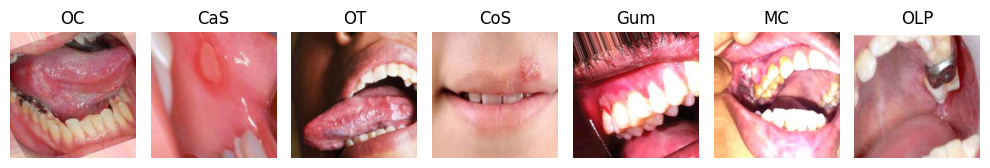

<Figure size 640x480 with 0 Axes>

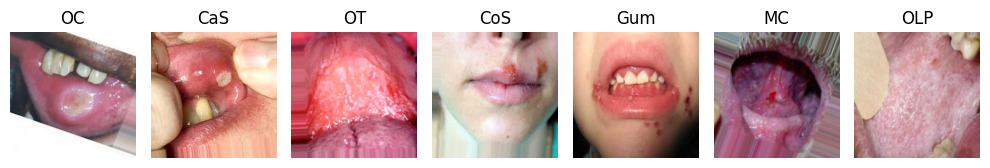

<Figure size 640x480 with 0 Axes>

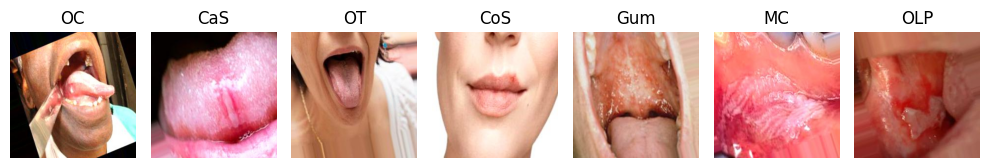

Text(0.5, 1.0, 'Random Images [Test Dataset]:')

<Figure size 640x480 with 0 Axes>

In [6]:
Illness = ['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP']
Types = ['Validation', 'Training', 'Testing']
def plot_one_image_per_illness(category, illness_list):

    fig, axes = plt.subplots(1, len(illness_list), figsize=(10, 10))
    if len(illness_list) == 1:
        axes = [axes]

    for ax, illness in zip(axes, illness_list):
        # illness_dir = "/kaggle/input/teeth-dataset/Teeth_Dataset/OC"
        illness_dir = os.path.join(base_path, category, illness)
        valid_extensions = ('.jpeg', '.jpg', '.bmp', '.png')
        #illness_image = list of the path of each image 
        illness_images = list(filter(lambda x: x.endswith(valid_extensions), os.listdir(illness_dir)))

        if illness_images:
            img_path = os.path.join(illness_dir, random.choice(illness_images))
            img = plt.imread(img_path)
            ax.imshow(img)
            ax.set_title(illness)
            ax.axis('off')
        else:
            ax.set_title(f'No images for {illness}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()


plot_one_image_per_illness(Types[0], Illness)
plt.suptitle('Random Images [Validation Dataset]:', y=1.00)

plot_one_image_per_illness(Types[1], Illness)
plt.suptitle('Random Images [Training Dataset]:', y=1.00)

plot_one_image_per_illness(Types[2], Illness)
plt.suptitle('Random Images [Test Dataset]:', y=1.00)

### 🧪 Data Loading & Preprocessing Function

This function `Load_and_preprocessing()` is responsible for preparing the training and validation datasets before feeding them into a Convolutional Neural Network (CNN). It performs two key tasks:

1. **Image Augmentation (Training Set Only)**:
   - Rescales pixel values from [0, 255] to [0, 1]
   - Applies random transformations to improve generalization:
     - Rotation
     - Width & height shift
     - Shearing
     - Zooming
     - Horizontal flipping

2. **Image Normalization (Validation Set)**:
   - Only rescales pixel values from [0, 255] to [0, 1] with no augmentation.

Both datasets are returned as generators using `flow_from_directory()` which:
- Reads images from folders named after each class.
- Resizes them to the specified `target_size` (e.g., 150x150).
- Returns batches of images and their corresponding one-hot encoded labels.

✅ This function helps the model learn from a more diverse set of images (via augmentation), which can reduce overfitting and improve performance on unseen data.


In [7]:
def Load_and_preprocessing(train_data, validation_data, target_size, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range = 0.2,
        shear_range= 0.2,
        zoom_range=0.2,
         horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_data,
        target_size = (150,150),
        batch_size=batch_size,
        class_mode = 'categorical'
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_data,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical'
    )


    return train_generator, validation_generator

In [8]:
train_generator, validation_generator = Load_and_preprocessing('/kaggle/input/teeth-dataset/Teeth_Dataset/Training',
                                                               '/kaggle/input/teeth-dataset/Teeth_Dataset/Validation',
                                                               target_size=(150, 150),
                                                                batch_size=32)
images, labels = next(train_generator)
print('Image batch shape:', images.shape)
print('Labels batch shape:', labels.shape)   

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Image batch shape: (32, 150, 150, 3)
Labels batch shape: (32, 7)


In [9]:
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


##  show_augmented_vs_original

In [10]:

def show_augmented_vs_original(train_generator, train_data_path, target_size=(150, 150), batch_size=32):
    
    plain_datagen = ImageDataGenerator(rescale=1./255)
    plain_generator = plain_datagen.flow_from_directory(
        train_data_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    class_names = list(plain_generator.class_indices.keys())
    shown_classes = set()

    plt.figure(figsize=(10, len(class_names) * 2))

    count = 0
    for _ in range(len(plain_generator)):
        x_orig, y = next(plain_generator)
        x_aug, _ = next(train_generator)

        class_index = np.argmax(y[0])
        class_name = class_names[class_index]

        if class_name not in shown_classes:
            shown_classes.add(class_name)

            # Show original
            plt.subplot(len(class_names), 2, count * 2 + 1)
            plt.imshow(x_orig[0])
            plt.title(f"Original - {class_name}")
            plt.axis("off")

            # Show augmented
            plt.subplot(len(class_names), 2, count * 2 + 2)
            plt.imshow(x_aug[0])
            plt.title(f"Augmented - {class_name}")
            plt.axis("off")

            count += 1

        if count == len(class_names):
            break

    plt.tight_layout()
    plt.show()


Found 3087 images belonging to 7 classes.


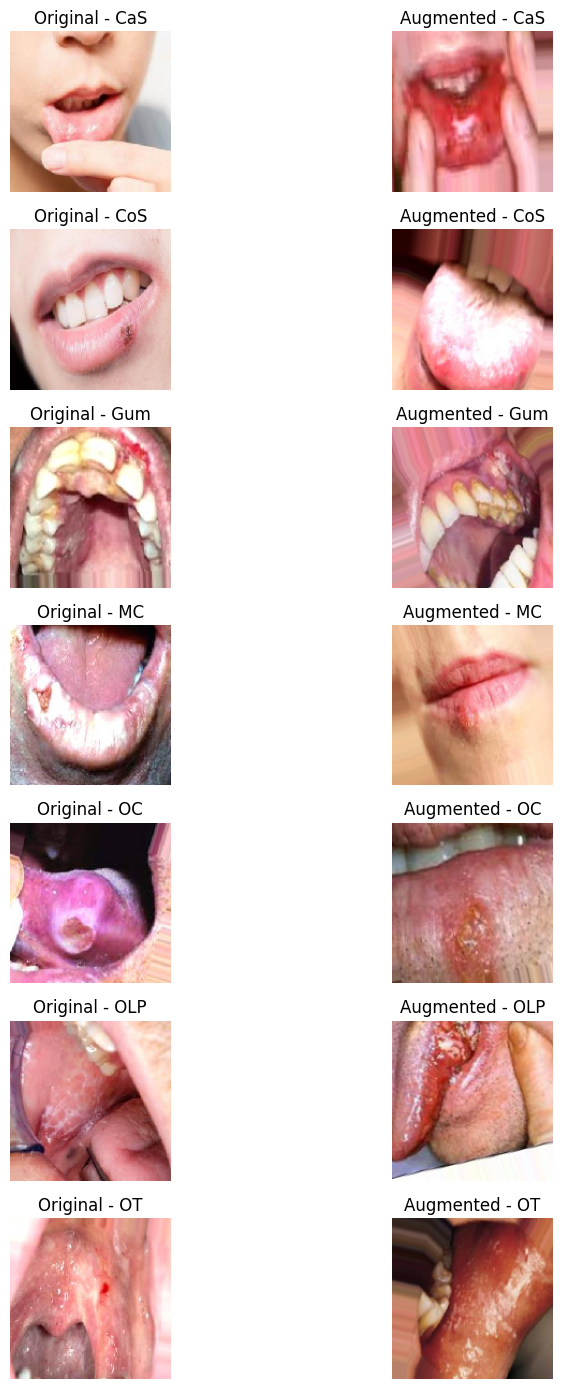

In [11]:
show_augmented_vs_original(train_generator, train_data_path='/kaggle/input/teeth-dataset/Teeth_Dataset/Training')

### 🧠 CNN Model Architecture for Teeth Disease Classification

The following Convolutional Neural Network (CNN) model is designed to classify input images into **7 disease categories** using a stack of convolutional and pooling layers followed by dense layers.

#### 📚 Layer-by-Layer Breakdown:

- **Conv2D (32 filters, 3×3 kernel, ReLU activation)**  
  Extracts 32 local features from the input image using small 3×3 filters.

- **MaxPooling2D (2×2 pool size)**  
  Reduces spatial dimensions (downsampling), helping the model become translation invariant.

- **Conv2D (64 filters, 3×3 kernel, ReLU activation)**  
  Learns more complex features by increasing the number of filters.

- **MaxPooling2D (2×2 pool size)**  
  Further reduces the feature map size.

- **Conv2D (128 filters, 3×3 kernel, ReLU activation)**  
  Adds depth to the feature representation for better discrimination.

- **MaxPooling2D (2×2 pool size)**  
  Downsamples the output again before flattening.

- **Flatten**  
  Converts the 2D feature maps into a 1D vector to feed into fully connected layers.

- **Dense (512 units, ReLU activation)**  
  A fully connected layer that acts as the final decision-making stage.

- **Dropout (rate = 0.5)**  
  Randomly turns off 50% of neurons during training to prevent overfitting.

- **Dense (7 units, Softmax activation)**  
  Outputs a probability distribution over the 7 classes (multi-class classification).

---

✅ This model balances simplicity and performance, making it suitable for image datasets like **Teeth_Dataset**. The use of dropout and ReLU activations helps combat overfitting and enables faster convergence during training.


In [12]:
model = Sequential([
    Conv2D(32,(3,3),activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7,activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,037,255 (72.62 MB)

 Trainable params: 19,037,255 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)
reduce_lr =  ReduceLROnPlateau(monitor='val_loss',factor =.2,patience=5, min_lr=0.00001)

In [16]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data = validation_generator,
    callbacks=[ reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1751415882.968707     100 service.cc:148] XLA service 0x7cdeb80085b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751415882.969516     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751415883.284058     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/97 ━━━━━━━━━━━━━━━━━━━━ 9:51 6s/step - accuracy: 0.0938 - loss: 1.9520

I0000 00:00:1751415886.507375     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 28s 231ms/step - accuracy: 0.1878 - loss: 2.2778 - val_accuracy: 0.2724 - val_loss: 1.8146 - learning_rate: 0.0010
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.2532 - loss: 1.8365 - val_accuracy: 0.3084 - val_loss: 1.7124 - learning_rate: 0.0010
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.3150 - loss: 1.7475 - val_accuracy: 0.3842 - val_loss: 1.5934 - learning_rate: 0.0010
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.3350 - loss: 1.6680 - val_accuracy: 0.4222 - val_loss: 1.5076 - learning_rate: 0.0010
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 201ms/step - accuracy: 0.3529 - loss: 1.6658 - val_accuracy: 0.4222 - val_loss: 1.4777 - learning_rate: 0.0010
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.3938 - loss: 1.5567 - val_accuracy: 0.4903 - val_loss: 1.3574 - learning_rate: 0.0010
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.4112 - loss: 1.5179 

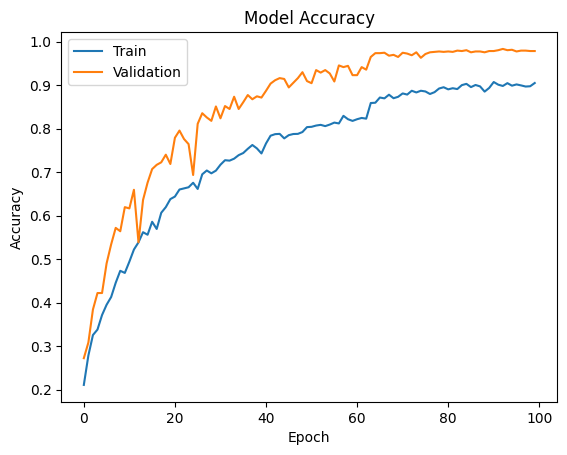

In [17]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

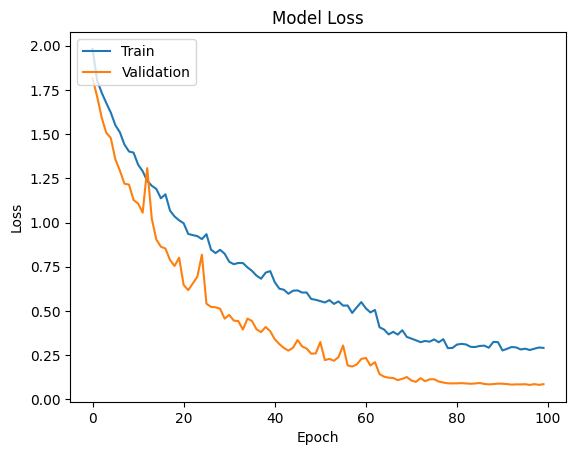

In [18]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
test_data = '/kaggle/input/teeth-dataset/Teeth_Dataset/Testing'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)


Found 1508 images belonging to 10 classes.


In [20]:
import shutil
import os

# Copy entire dataset to a writable directory
src = '/kaggle/input/teeth-dataset/Teeth_Dataset'
dst = '/kaggle/working/teeth-dataset/Teeth_Dataset'
shutil.copytree(src, dst)

'/kaggle/working/teeth-dataset/Teeth_Dataset'

In [21]:
# Now you can delete, move, or modify files in the working directory
shutil.rmtree('/kaggle/working/teeth-dataset/Teeth_Dataset/Testing/out')

In [22]:
shutil.rmtree('/kaggle/working/teeth-dataset/Teeth_Dataset/Testing/outputs')

In [23]:
shutil.rmtree('/kaggle/working/teeth-dataset/Teeth_Dataset/Testing/output')

In [27]:
test_data = '/kaggle/working/teeth-dataset/Teeth_Dataset/Testing'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)


Found 1028 images belonging to 7 classes.


In [28]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9838 - loss: 0.0679
Test Loss: 0.077102892100811
Test Accuracy: 0.981517493724823


In [29]:
from sklearn.metrics import classification_report


# Step 1: Make predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Step 2: Get the true labels
y_true = test_generator.classes

# Step 3: Get class labels (names)
class_labels = list(test_generator.class_indices.keys())

# Step 4: Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
              precision    recall  f1-score   support

         CaS       0.99      0.99      0.99       160
         CoS       1.00      0.99      0.99       149
         Gum       0.99      0.98      0.99       120
          MC       0.97      0.96      0.97       180
          OC       0.95      0.98      0.96       108
         OLP       0.98      0.98      0.98       180
          OT       0.98      0.99      0.98       131

    accuracy                           0.98      1028
   macro avg       0.98      0.98      0.98      1028
weighted avg       0.98      0.98      0.98      1028



33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


<Figure size 800x600 with 0 Axes>

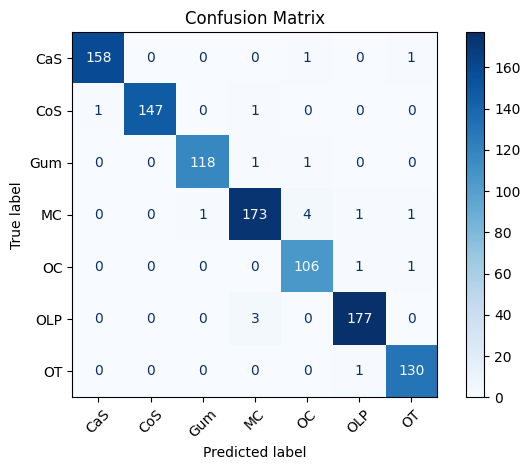

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


true_labels = test_generator.classes
predictions = model.predict(test_generator)


predicted_labels = np.argmax(predictions, axis=1)
class_names = list(test_generator.class_indices.keys())


cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()
